## gasification H2/CO _ 2 bins 70/30 _ lr = 1e-3 _ 100 epochs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from typing import Any, Collection, Dict, List, Optional, Tuple, Union
from numpy.typing import ArrayLike
from fastcore.all import L
import pycm

In [3]:
def evaluate_classification(
    y_true: ArrayLike,
    y_pred: ArrayLike,
) -> Dict[str, Any]:
    """Evaluate a classification task.

    Args:
        y_true (ArrayLike): The true labels.
        y_pred (ArrayLike): The predicted labels.

    Returns:
        Dict[str, Any]: A dictionary of metrics.
    """
    might_have_rounded_floats = False
    assert len(y_true) == len(y_pred), "y_true and y_pred must be the same length."
    y_true = L([int(x) for x in y_true])

    y_pred_new = []
    int_indices = []
    for i, x in enumerate(y_pred):
        try:
            x_int = int(x)
            if x_int != x:
                might_have_rounded_floats = True
                logger.warning("y_pred contains rounded floats.")
            y_pred_new.append(x_int)
            int_indices.append(i)
        except Exception as e:
            y_pred_new.append(None)
    y_pred_new = L(y_pred_new)

    frac_valid = len(int_indices) / len(y_true)
    if len(int_indices) == 0:
        logger.warning("No valid predictions found.")
        y_pred_valid = L([None] * len(y_true))
        y_true_valid = y_true

    else:
        y_true_valid = y_true[int_indices]
        y_pred_valid = y_pred_new[int_indices]

    cm = pycm.ConfusionMatrix(list(y_true_valid), list(y_pred_valid))
    return {
        "accuracy": cm.Overall_ACC,
        "acc_macro": cm.ACC_Macro,
        "racc": cm.Overall_RACC,
        "kappa": cm.Kappa,
        "confusion_matrix": cm,
        "f1_macro": cm.F1_Macro,
        "f1_micro": cm.F1_Micro,
        "frac_valid": frac_valid,
        "all_y_true": y_true,
        "all_y_pred": y_pred,
        "valid_indices": int_indices,
        "might_have_rounded_floats": might_have_rounded_floats,
    }

In [4]:
from glob import glob
from fastcore.xtras import load_pickle
import os 
import pandas as pd
from sklearn import metrics

import matplotlib.pyplot as plt 
import matplotlib as mpl
#import seaborn as sns
import numpy as np 

from scipy.stats import sem
from scipy.constants import golden
ONE_COL_WIDTH_INCH = 3.25
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

import sys

sys.path.append("../plotutils/")
from plotutils import *

plt.style.use("../plotutils/your.mplstyle")

import matplotx

In [5]:
all_res = glob(f"./*.pkl")
print(f"Pickles found: {len(all_res)}")

Pickles found: 82


### ADJUST dictionary according to experiment

In [6]:
compiled_res_list = []
conf_mats = []

for res in all_res:
    res = load_pickle(res)
    nan_prediction_mask = np.isnan(res["predictions"])
    try:
        results = evaluate_classification(res["targets"], res["predictions"][~nan_prediction_mask])
    except:
        results = evaluate_classification(res["true"], res["predictions"][~nan_prediction_mask])
    summary = {
        'train_size': res['train_size'],
        'accuracy': results['accuracy'],
        'acc_macro': results['acc_macro'],
        'racc': results['racc'],
        'kappa': results['kappa'],
        'f1_macro': results['f1_macro'],
        'f1_micro': results['f1_micro'],
        'frac_valid': results['frac_valid'],
        'valid_indices': results['valid_indices'],
        'might_have_rounded_floats': results['might_have_rounded_floats'],
    }
    
    confusion_matrix = {
        'all_y_true': results['all_y_true'],
        'all_y_pred': results['all_y_pred']
    }
    
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

In [7]:
compiled_res = pd.DataFrame(compiled_res_list)

In [8]:
compiled_res = compiled_res.iloc[:, 0:8]
compiled_res

,train_size,accuracy,acc_macro,racc,kappa,f1_macro,f1_micro,frac_valid
0,10,0.625000,0.625000,0.630000,-0.013514,0.482312,0.625000,1.0
1,5,0.533333,0.533333,0.560988,-0.062992,0.465800,0.533333,1.0
2,15,0.600000,0.600000,0.640816,-0.113636,0.432870,0.600000,1.0
3,20,0.633333,0.633333,0.620000,0.035088,0.511111,0.633333,1.0
4,25,0.600000,0.600000,0.632000,-0.086957,0.451754,0.600000,1.0
...,...,...,...,...,...,...,...,...
77,15,0.771429,0.771429,0.689796,0.263158,0.597701,0.771429,1.0
78,20,0.800000,0.800000,0.660000,0.411765,0.687500,0.800000,1.0
79,25,0.760000,0.760000,0.667200,0.278846,0.625000,0.760000,1.0
80,30,0.700000,0.700000,0.660000,0.117647,0.531250,0.700000,1.0


### ADJUST columns according to grouping

In [9]:
grouped_res = compiled_res.groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy           acc_macro                racc            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5           0.584444  0.025671  0.584444  0.025671  0.586716  0.024244   
10          0.620000  0.013844  0.620000  0.013844  0.628000  0.009404   
15          0.677143  0.016523  0.677143  0.016523  0.646939  0.014131   
20          0.673333  0.017778  0.673333  0.017778  0.641333  0.006652   
25          0.632000  0.024440  0.632000  0.024440  0.633280  0.008429   
30          0.645000  0.029297  0.645000  0.029297  0.626000  0.013013   
35          0.700000  0.024845  0.700000  0.024845  0.641333  0.014801   
40          0.666667  0.033333  0.666667  0.033333  0.580000  0.010328   
45          0.700000  0.068313  0.700000  0.068313  0.580000  0.048166   

               kappa            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
5          -0.009205  0.037030  0.467042  0.017672  0.584444  0.025671   
10         -0.022534  0.030944  0.473930  0.016569  0.620000  0.013844   
15          0.080512  0.045112  0.514809  0.025589  0.677143  0.016523   
20          0.092129  0.040788  0.528686  0.020348  0.673333  0.017778   
25         -0.008135  0.072372  0.483910  0.038241  0.632000  0.024440   
30          0.048411  0.069787  0.507372  0.035935  0.645000  0.029297   
35          0.157963  0.070837  0.564264  0.039745  0.700000  0.024845   
40          0.204170  0.080906  0.600611  0.040238  0.666667  0.033333   
45          0.269481  0.195795  0.613095  0.097808  0.700000  0.068313   

           frac_valid       
                 mean  sem  
train_size                  
5                 1.0  0.0  
10                1.0  0.0  
15                1.0  0.0  
20                1.0  0.0  
25                1.0  0.0  
30                1.0  0.0  
35                1.0  0.0  
40                1.0  0.0  
45                1.0  0.0

[[0.70833333 0.29166667]
 [0.33333333 0.66666667]]
accuracy: 0.6875


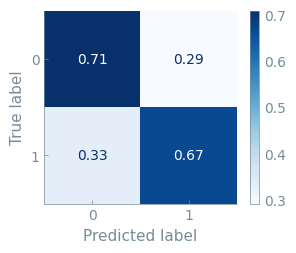

In [10]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]
confusion_matrix_max = []
for index, _ in enumerate(conf_mats_max):
    try:
        preds = conf_mats_max[index]
        actual = preds["all_y_true"]
        predicted = preds["all_y_pred"]
        confusion_matrix = metrics.confusion_matrix(actual, predicted)
        confusion_matrix_max.append(confusion_matrix)
    except Exception as e:
        print(e)
norm_confusion_matrix = sum(confusion_matrix_max)/[[sum(sum(confusion_matrix_max)[0])], [sum(sum(confusion_matrix_max)[1])]]
print(norm_confusion_matrix)

acc1=0
for i in range(len(norm_confusion_matrix)):
    acc=norm_confusion_matrix[i][i]
    acc1=acc1+acc
acc=acc1/sum(sum(norm_confusion_matrix))

print(f'accuracy: {acc}')

cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = norm_confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.savefig('classif_H2CO_confusionMatrix_70_30_100ep_size45.pdf', bbox_inches='tight')

In [11]:
sizes = np.sort(compiled_res["train_size"].unique())
print(sizes)

[ 5 10 15 20 25 30 35 40 45]


In [12]:
print(grouped_res.loc[sizes, :]['accuracy'])

                mean       sem
train_size                    
5           0.584444  0.025671
10          0.620000  0.013844
15          0.677143  0.016523
20          0.673333  0.017778
25          0.632000  0.024440
30          0.645000  0.029297
35          0.700000  0.024845
40          0.666667  0.033333
45          0.700000  0.068313


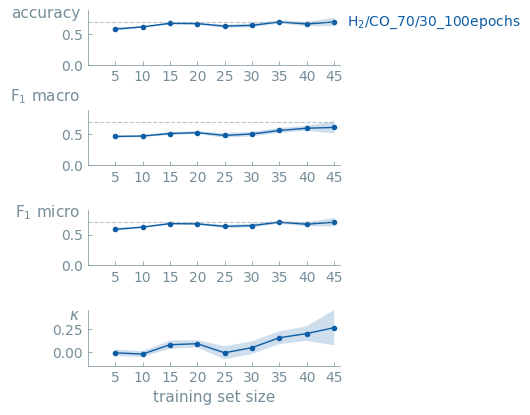

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH))

n_bins = 2
representations = ['70/30_100epochs']

for representation in representations:
    ax[0].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['accuracy']['mean'],
        marker='o',
        label=f'H$_2$/CO_{representation}'
    )
    ax[0].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['accuracy']['mean']
        -grouped_res.loc[sizes, :]['accuracy']['sem'],
        grouped_res.loc[sizes, :]['accuracy']['mean']
        +grouped_res.loc[sizes, :]['accuracy']['sem'],
        alpha = 0.2
    )
    
    ax[0].hlines(0.7, 0, 45, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ylabel_top('accuracy', ax=ax[0])
    ax[0].set_xticks(sizes)
    ax[0].set_xlim(0, 46)
    ax[0].set_ylim(0, 0.9)

    ax[1].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_macro']['mean'],
        marker='o',
        label=f'{representation}'
    )
    ax[1].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_macro']['mean']
        -grouped_res.loc[sizes, :]['f1_macro']['sem'],
        grouped_res.loc[sizes, :]['f1_macro']['mean']
        +grouped_res.loc[sizes, :]['f1_macro']['sem'],
        alpha=0.2
    )

    ax[1].hlines(0.7, 0, 45, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ylabel_top(r'F$_1$ macro', ax=ax[1])
    ax[1].set_xticks(sizes)
    ax[1].set_xlim(0, 46)
    ax[1].set_ylim(0, 0.9)

    ax[2].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_micro']['mean'],
        marker='o',
        label=f'{representation}'
    )

    ax[2].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['f1_micro']['mean']
        -grouped_res.loc[sizes, :]['f1_micro']['sem'],
        grouped_res.loc[sizes, :]['f1_micro']['mean']
        +grouped_res.loc[sizes, :]['f1_micro']['sem'],
        alpha=0.2
    )

    ax[2].hlines(0.7, 0, 45, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ylabel_top(r'F$_1$ micro', ax=ax[2])
    ax[2].set_xticks(sizes)
    ax[2].set_xlim(0, 46)
    ax[2].set_ylim(0, 0.9)

    ax[3].plot(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['kappa']['mean'],
        marker='o',
        label=f'{representation}'
    )
    ax[3].fill_between(
        grouped_res.loc[sizes, :].index,
        grouped_res.loc[sizes, :]['kappa']['mean']
        -grouped_res.loc[sizes, :]['kappa']['sem'],
        grouped_res.loc[sizes, :]['kappa']['mean']
        +grouped_res.loc[sizes, :]['kappa']['sem'],
        alpha=0.2
    )
    
    ax[3].hlines(0, 0, 0, linestyle='--', color='#758D99', alpha=0.5, linewidth=0.8)
    ax[3].hlines(-0.15, 0, 0, linestyle='--', color='#758D99', alpha=0.5)
    ylabel_top(r'$\kappa$', ax=ax[3])
    ax[3].set_xticks(sizes)
    ax[3].set_xlim(0, 46)

ax[-1].set_xlabel('training set size')

matplotx.line_labels(ax[0])
plt.subplots_adjust(hspace=0.8, top=1, bottom=0.2)
fig.savefig('classif_H2COgasif_70_30_100ep_size45.pdf', bbox_inches='tight')